## Import required modules

In [157]:
# ===========================================================================
# import required modules
# ===========================================================================
import os

# ===================
# for array manipulations, etc.
# ===================
import random
import numpy as np

# ===================
# for visualization
# ===================
from matplotlib import pyplot as plt

# ===================
# pytorch for CNN related things
# ===================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"cuda or not: {device}")

cuda or not: cuda


In [3]:
# torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device(device)

In [4]:
torch.cuda.get_device_name()

'GeForce RTX 2060 with Max-Q Design'

## Set path to the STL dataset


In [5]:
STL_path = '/home/lukas/git/ethz-iacv-2020/dataset/stl10_binary'

## Load the dataset (images + labels)


In [6]:

# ===================
# function to load the dataset and format the data as required for further processing 
# ===================
# inputs:
#    split: string denoting whether the train or the test data is to be loaded 
# outputs:
#    X: dataset inputs (images)
#    y: dataset outputs (labels for the images)
# ===================
def load_split(dataset_root, split):
    X_path = '{}/{}_X.bin'.format(dataset_root, split)
    y_path = '{}/{}_y.bin'.format(dataset_root, split)
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y

# ===================
# load the training and test datasets
# ===================
full_train_X, full_train_y = load_split(STL_path, 'train')
full_test_X, full_test_y = load_split(STL_path, 'test')

# ===================
# read the names of the classes in the dataset
# ===================
with open('{}/class_names.txt'.format(STL_path)) as f:
    full_class_names = f.readlines()
  
 # ===================
 # strip trailing whitespace
 # ===================
full_class_names = [name.strip() for name in full_class_names]

# ===================
# print the list of names of all classes
# ===================
print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)
-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


## Explore a few samples of the dataset

In [7]:
# ===========================================================================
# Explore a few samples of the dataset
# (repeat the following cell for different output by pressing Ctrl-Enter on it instead of Shift-Enter)
# ===========================================================================

# ===================
# function to show an example image and its label
# ===================
# inputs:
#    X: image
#    y: label
#    class_names: list of names of all classes so that the class name corresponding to the label can be identified
# outputs:
#    None
# ===================
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

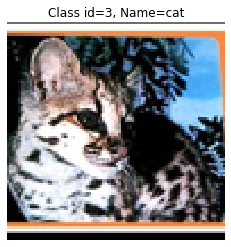

In [8]:
# ===================
# choose a random image and display it 
# you may run this cell multiple times to get an idea of the different images in the dataset
# alternatively, modify the function 'visualize_sample' to display several (4/8/16) different images 
# along with their labels
# ===================
i = random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

# Train a 2-class classifier. 

First we will generate a dataset with just two classes, 'cat' and 'ship'

In [9]:
# ===================
# Let's select from the dataset only samples of classes 'cat' and 'ship'.
# We have arbitrarily chosen these two classes.
# You may try some other pair of classes if you wish to.
# ===================
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

# ===================
# function to delete all the classes other than the cat and ship classes
# ===================
# inputs:
#    X: images from all classes
#    y: labels from all classes
#    split: train / test
# outputs:
#    X_out: images from only cats and ships
#    y_out: labels from only cats and ships
# ===================
def subsplit_two_classes(X, y, split):
    
    indices = np.where(np.logical_or(y==ID_C1_OLD,
                                   y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.int) * ID_C1_NEW + \
            (y_out == ID_C2_OLD).astype(np.int) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

# ===================
# make the training and test datasets so that they contain only the two classes of interest
# ===================
train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


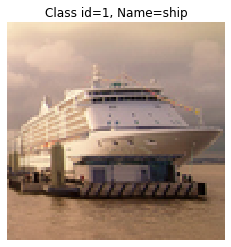

In [10]:
# ===================
# visualize some examples from the modified datasets
# ===================
i = random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

## Wrap our dataset into pytorch Dataset class so it can further be used in DataLoader for batch grouping


In [11]:
class ArrayDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]
  
 # ===================
 # set the batch size here
 # ===================
BATCH_SIZE = 8

# ===================
# load the training and test datasets for the two-class classification problem
# https://pytorch.org/docs/stable/data.html
# ===================
loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

# ===================
# load the training and test datasets for the ten-class classification problem
# ===================
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                     batch_size=1,
                                     shuffle=True)

## Define the neural network


In [64]:
class CNN(nn.Module):
  
  # ===================
  # the network architecture is defined here
  # documentation of some useful functions:
  #     https://pytorch.org/docs/stable/nn.html#conv2d
  #     https://pytorch.org/docs/stable/nn.html#batchnorm2d
  #     https://pytorch.org/docs/stable/nn.html#maxpool2d
  #     https://pytorch.org/docs/stable/nn.html#linear
  #     https://pytorch.org/docs/stable/nn.html#batchnorm1d
  # ===================
    
    last_layer_1_features = None
    
    def __init__(self, num_out_classes):
    
        super(CNN, self).__init__()
        
        num_filters = [3, 12, 24, 48, 128, 256, 128] 
        # num_filters = [i * 2 for i in num_filters]
        # num_filters[0] = 3
        self.n_filters = num_filters
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=num_filters[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            # expected size of input to following layer: 8x6x48x48
            nn.Conv2d(in_channels=num_filters[1],
                                   out_channels=num_filters[2],
                                   kernel_size=3,
                                   padding=1,
                                   bias=False),
            # expected size of input to following layer:
            nn.BatchNorm2d(num_features=num_filters[2]),
            # expected size of input to following layer:
            nn.ReLU(),
            # expected size of input to following layer:
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
                
        self.layer3 = nn.Sequential(
            # expected size of input to following layer: 8x12x24x24
            nn.Conv2d(in_channels=num_filters[2],
                                   out_channels=num_filters[3],
                                   kernel_size=3,
                                   padding=1,
                                   bias=False),
            # expected size of input to following layer:
            nn.BatchNorm2d(num_features=num_filters[3]),
            # expected size of input to following layer:
            nn.ReLU(),
            # expected size of input to following layer:
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
         
        self.layer4 = nn.Sequential(
            # expected size of input to following layer: 8x24x12x12
            nn.Conv2d(in_channels=num_filters[3],
                                   out_channels=num_filters[4],
                                   kernel_size=3,
                                   padding=1,
                                   bias=False),
            # expected size of input to following layer:
            nn.BatchNorm2d(num_features=num_filters[4]),
            # expected size of input to following layer:
            nn.ReLU(),
            # expected size of input to following layer:
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
            
        self.layer5 = nn.Sequential(
            # expected size of input to following layer: 8x24x11x11
            nn.Linear(in_features=num_filters[4]*11*11,
                                 out_features=num_filters[5]),
            # expected size of input to following layer:
            nn.BatchNorm1d(num_features=num_filters[5]),
            # expected size of input to following layer:
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=num_filters[5],
                                 out_features=num_filters[6]),
            # expected size of input to following layer:
            nn.BatchNorm1d(num_features=num_filters[6]),
            # expected size of input to following layer:
            nn.ReLU()
        )

        # expected size of input to following layer: 8*64
        self.fc1 = nn.Linear(in_features=num_filters[6],  # 64 neurons
                             out_features=num_out_classes)  # 2
        
        # single-layer perceptron neural network
        # self.perceptron = nn.Linear(in_features=3*96*96,
        #                            out_features=num_out_classes)

    # ===================
    # define the forward pass through the network using the operations defined in the init function
    # ===================
    def forward(self, x):
        # bring input to [-1,1] range
        x = x.float() / 128.0 - 1.0
        # ===================
        # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
        # (to be implemented)
        # ===================
        # x = x.view(-1, 3*96*96)
        # x = self.perceptron(x)

        out = self.layer1(x)
        self.last_layer_1_features = out
        # print(f"out1 = {out.shape}")
        out = self.layer2(out)
        # print(f"out2 = {out.shape}")
        out = self.layer3(out)
        # print(f"out3 = {out.shape}")
        out = self.layer4(out)
        # print(f"out4 = {out.shape}")
        out = out.view(-1, self.n_filters[4]*11*11)
        # print(f"out3 = {out.shape}")
        out = self.layer5(out)
        # print(f"out5 = {out.shape}")
        out = self.layer6(out)
        # print(f"out6 = {out.shape}")
        x = self.fc1(out)
        # print(f"x = {x.shape}")
        
        return x
    
    def get_last_layer_1_features(self):
        return self.last_layer_1_features

In [52]:
cnn_two_classes = CNN(num_out_classes = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_two_classes = cnn_two_classes.to(device)

# ===========================================================================
# compute the accuracy of the CNN
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train',
                 device=device)

Accuracy over "train" split is 50.000000%


50.0

In [13]:
nn = CNN(num_out_classes=10)

## Function to compute the accuracy of the CNN

In [14]:
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True,
                     device="cpu"):
  
    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0
    tdevice = torch.device(device)  

    for i, batch in enumerate(data_loader):

        # get the inputs and labels
        X_batch, y_batch = batch
        X_batch = X_batch.to(tdevice)  # same device as CNN
        y_batch = y_batch.to(tdevice)  # same device as CNN
        

        # calculate predictions given a batch of samples
        predictions_batch = cnn(X_batch)

        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)

        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]

        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print('Accuracy over "{}" split is {:02f}%'.format(split, 100 * out_accuracy))

    return 100 * out_accuracy

## Function for training the model. 


In [61]:
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = False,
          device="cpu"):
  
    # ===================
    # define the loss to be minimized
    # https://pytorch.org/docs/stable/nn.html#crossentropyloss
    # ===================
    criterion = nn.CrossEntropyLoss()

    # ===================
    # create an optimizer 
    # You can read more about optimizers here: https://pytorch.org/docs/stable/optim.html
    # You may try with different optimizers and check if that makes any difference
    # For any one optimizer, try changing the learning rate and observe the effect.
    # ===================
    optimizer = optim.SGD(cnn.parameters(),
                        lr = learning_rate,
                        weight_decay = 0.01,
                        momentum = 0.9)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    

    # ===================
    # set the model into training mode
    # ===================
    cnn.train() 

    tr_acc = []
    ts_acc = []

    if isinstance(device, str):
        tdevice = torch.device(device)  
    else:
        tdevice = device
    
    # ===================
    # In each epoch, run the optimizer operation on each batch
    # ===================
    for epoch in range(num_epochs):
            
        epoch_loss = 0.0

        for i, batch in enumerate(loader_train):

            X_batch, y_batch = batch
            X_batch = X_batch.to(tdevice)  # same device as CNN
            y_batch = y_batch.type(torch.long)
            y_batch = y_batch.to(tdevice)  # same device as CNN

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            predictions_batch = cnn(X_batch)
            # print(f"1 predictions_batch={predictions_batch.shape} y_batch={y_batch.shape}")
            
            # calculate loss for the provided predictions and ground truth labels
            # y_batch = torch.max(predictions_batch, 1)[1]
            # print(f"2 y_batch={y_batch.shape}")
            
            loss = criterion(predictions_batch, y_batch)

            epoch_loss += float(loss)

            # backward pass
            loss.backward()

            # update learnable parameters according to gradients
            optimizer.step()
        lr_scheduler.step(epoch_loss)
            
        # ===================
        # track the training and test accuracy.
        # note that this adds quite a bit to the training time,
        # as things are running on the cpu currently.
        # this is usually a good debugging tool to see how the training is progressing
        # and is usually done when people train such networks on gpus.
        # ===================
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False,
                                           device=device))
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False,
                                           device=device))

        epoch_loss /= len(loader_train)
        print('Epoch {}/{} training loss {:02f}'.format(epoch+1, num_epochs, epoch_loss))

    if track_accuracy:
        plt.figure()
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['training accuracy', 'test accuracy'])
        plt.xlabel('training iterations')
        plt.show()
        plt.close()

    print('Finished Training')

## Create an instance of the above defined CNN class and compute it's accuracy before training. What do you expect the accuracy to be??

In [33]:
# ===========================================================================
# create an instance of the above defined CNN class
# ===========================================================================
cnn_two_classes = CNN(num_out_classes = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"cuda or not: {device}")
cnn_two_classes = cnn_two_classes.to(device)

# ===========================================================================
# compute the accuracy of the CNN
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train',
                 device=device)

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test',
                 device=device)

cuda or not: cuda
Accuracy over "train" split is 50.000000%
Accuracy over "test" split is 50.000000%


50.0

In [34]:
isinstance(device, str)

False

## Train the network now and reevaluate it's accuracy

Epoch 1/10 training loss 0.344908
Epoch 2/10 training loss 0.225211
Epoch 3/10 training loss 0.128038
Epoch 4/10 training loss 0.072195
Epoch 5/10 training loss 0.040719
Epoch 6/10 training loss 0.020216
Epoch 7/10 training loss 0.005986
Epoch 8/10 training loss 0.001456
Epoch 9/10 training loss 0.000720
Epoch 10/10 training loss 0.000560


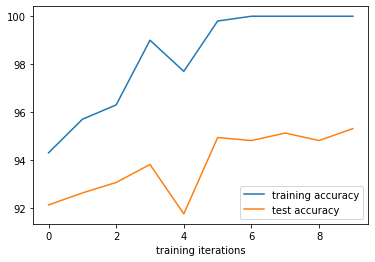

Finished Training
Accuracy over "train" split is 100.000000%
Accuracy over "test" split is 95.312500%


95.3125

In [22]:
# ===========================================================================
# call the train function and wait for the magic to unfold ;)
# ===========================================================================
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 10,
      track_accuracy = True,
      device=device)

# ===========================================================================
# Let's reevaluate accuracy now. Did the magic happen?
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train',
                 device=device)

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test',
                 device=device)

# Multi-class classification



The 2-class classification CNN works well. Now, let's try to apply the same approach to multi-class classification problem. Remember that the original dataset has 10 classes. So all that needs to be done is create a new CNN with 10 output classes, and train once again.






In [65]:
# ===========================================================================
# create a new instance of the CNN class, to do the classification for all the ten classes
# ===========================================================================
cnn_ten_classes = CNN(num_out_classes = 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"cuda or not: {device}")
cnn_ten_classes = cnn_ten_classes.to(device)

# ===========================================================================
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train',
                                           device=device)

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test',
                                           device=device)

cuda or not: cuda
Accuracy over "train" split is 10.000000%
Accuracy over "test" split is 10.000000%


10.0

In [66]:
num_trainable_params = sum(p.numel() for p in cnn_ten_classes.parameters() if p.requires_grad)
num_trainable_params

4069142

Epoch 1/25 training loss 1.652795
Epoch 2/25 training loss 1.419907
Epoch 3/25 training loss 1.137937
Epoch 4/25 training loss 0.929430
Epoch 5/25 training loss 0.759317
Epoch 6/25 training loss 0.576803
Epoch 7/25 training loss 0.426506
Epoch 8/25 training loss 0.286956
Epoch 9/25 training loss 0.205603
Epoch 10/25 training loss 0.129342
Epoch 11/25 training loss 0.114264
Epoch 12/25 training loss 0.093840
Epoch 13/25 training loss 0.059670
Epoch 14/25 training loss 0.056234
Epoch 15/25 training loss 0.087443
Epoch 16/25 training loss 0.054647
Epoch 17/25 training loss 0.039971
Epoch 18/25 training loss 0.074672
Epoch 19/25 training loss 0.078909
Epoch 20/25 training loss 0.100889
Epoch 21/25 training loss 0.030516
Epoch 22/25 training loss 0.014815
Epoch 23/25 training loss 0.012692
Epoch 24/25 training loss 0.011906
Epoch 25/25 training loss 0.011741


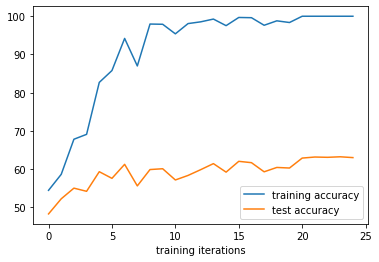

Finished Training
Accuracy over "train" split is 100.000000%
Accuracy over "test" split is 63.037500%


63.0375

In [67]:
# ===========================================================================
# train this new CNN...
# ===========================================================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 25,
      track_accuracy = True,
                                           device=device)

# ===========================================================================
# compute the accuracy with the trained CNN...
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train',
                                           device=device)

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test',
                                           device=device)

In [170]:
img_id = np.random.randint(0, full_test_X.shape[0])
test_img = full_test_X[img_id]
test_img.shape

(3, 96, 96)

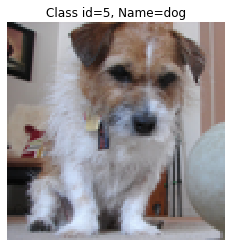

In [171]:
visualize_sample(test_img,
                 full_test_y[img_id],
                 full_class_names)

In [76]:
full_test_y[0]

6

In [172]:

test_img_d = np.expand_dims(test_img, axis=0)
print(f"test_img = {test_img_d.shape}")
print(f"Ground truth: {full_test_y[img_id]}")
ti = torch.from_numpy(test_img_d)
ti = ti.to(device)

pred_X = cnn_ten_classes(ti)
print(pred_X)
print("prediction: ", np.argmax(pred_X.cpu().detach().numpy()))

test_img = (1, 3, 96, 96)
Ground truth: 5
tensor([[-2.6723,  2.5525, -4.6509,  1.4465, -4.2315,  8.6521,  1.7955,  4.1148,
         -3.3874, -2.7449]], device='cuda:0', grad_fn=<AddmmBackward>)
prediction:  5


In [173]:
features = cnn_ten_classes.get_last_layer_1_features()
features.shape

torch.Size([1, 12, 48, 48])

In [121]:
features_arr = features.cpu().detach().numpy()
features_arr = features_arr.squeeze()

In [122]:
features_arr.shape

(12, 48, 48)

In [ ]:
plot_weights(alexnet, 0, single_channel = False)

In [134]:
l1_weights = cnn_ten_classes.layer1[0].weight.cpu().detach()
l1_weights.shape

torch.Size([12, 3, 3, 3])

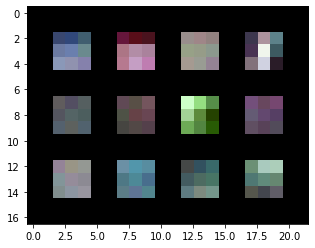

In [135]:
# normalize to (0,1) range so that matplotlib
# can plot them
kernels = l1_weights
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 4)
# change ordering since matplotlib requires images to 
# be (H, W, C)
plt.imshow(filter_img.permute(1, 2, 0))

In [137]:
l2_weights = cnn_ten_classes.layer2[0].weight.cpu().detach()
l2_weights.shape

torch.Size([24, 12, 3, 3])

In [153]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)    
    
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()
    
def plot_weights(weight_tensor, single_channel = True, collated = False):
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)

    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")


layer dimensions: torch.Size([12, 3, 3, 3])


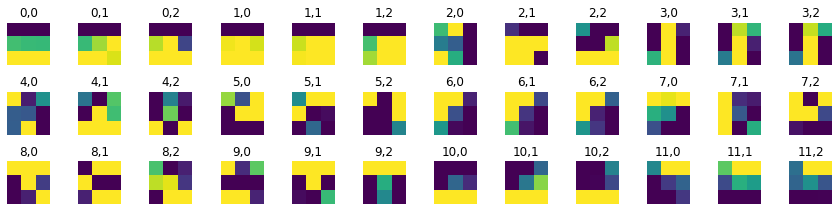

In [161]:
l1 = cnn_ten_classes.layer1[0].weight.cpu().data
print(f"layer dimensions: {l1.shape}")
plot_weights(l1, single_channel=True, collated=False)

layer dimensions: torch.Size([24, 12, 3, 3])


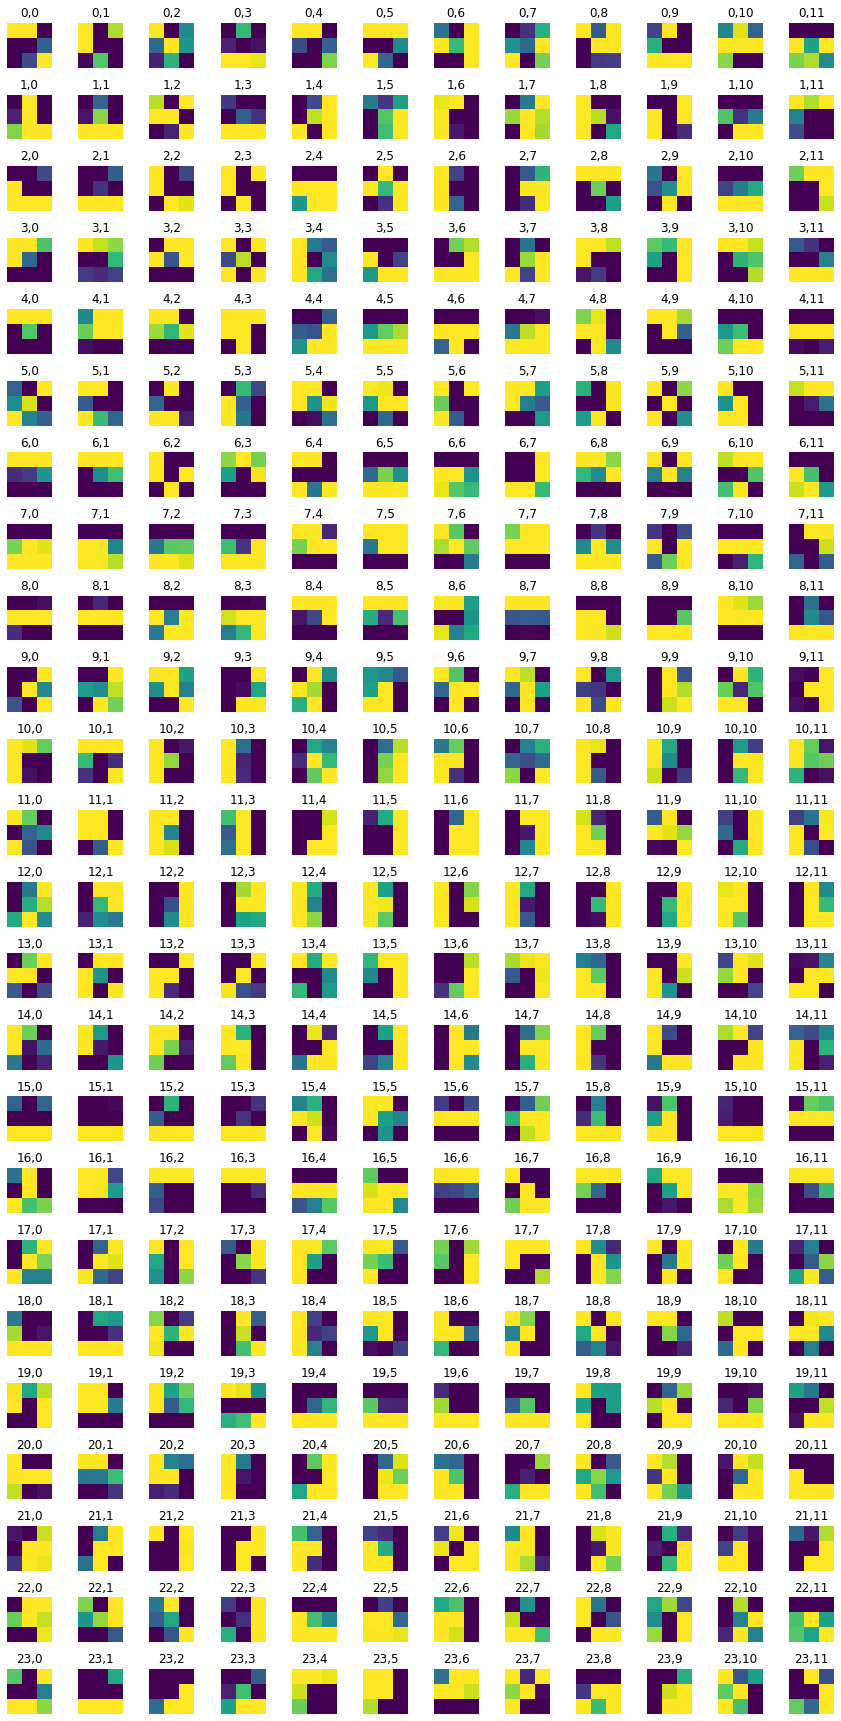

In [149]:
l = cnn_ten_classes.layer2[0].weight.cpu().data
print(f"layer dimensions: {l.shape}")
plot_weights(l)

In [174]:
features = cnn_ten_classes.get_last_layer_1_features()
features.shape

torch.Size([1, 12, 48, 48])

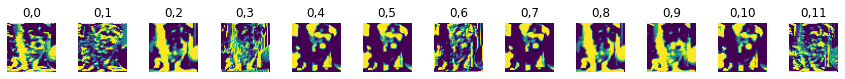

In [175]:
plot_weights(features.cpu().detach())